In [1]:
import yaml
import sys
import os
import numpy as np
import torch 
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

%load_ext autoreload
%autoreload 2

import importlib
import sys
try:
    importlib.reload(sys.modules['loaders_v2'])
except:
    pass
import loaders_v2
from loaders_v2 import GenericDataset
import importlib
importlib.reload(loaders_v2)
from rotations import * 
exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_ws_deepim_debug_natrix.yml'
env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

Start loading meshes
Finished loading meshes 36.50243830680847


Finished with 500 matches and within 723 iteartions, len(out), 40919
Finished with 500 matches and within 1253 iteartions, len(out), 19620
Time to get flow 3.5618839263916016
x_map:


/home/jonfrey/PLR3/src/helper/bounding_box.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  masked_idx = (d != 0).nonzero()


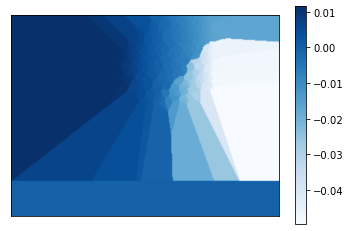

y_map:


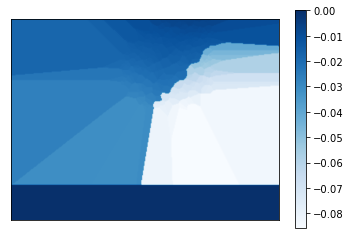

z_map:


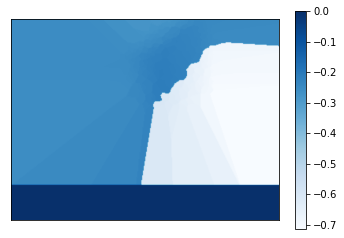

u_map:


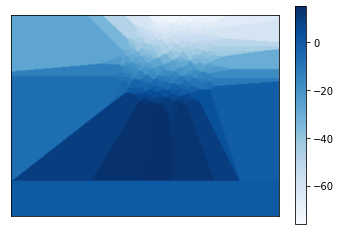

v_map:


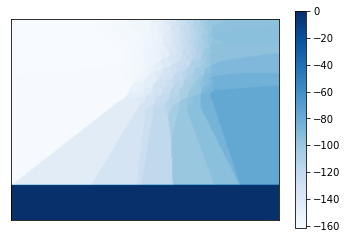

torch.Size([1, 480, 640, 3])


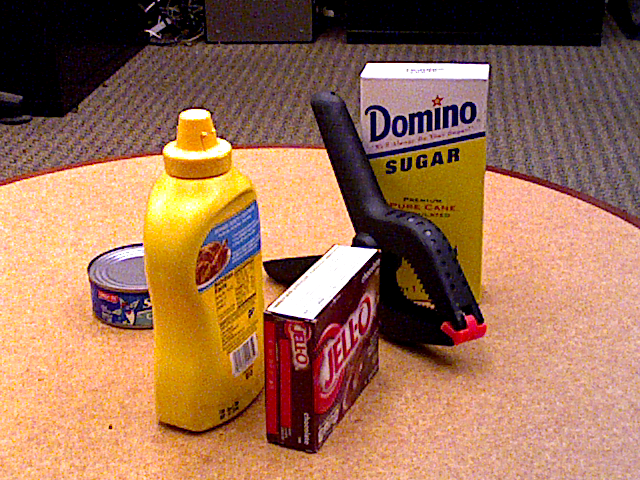

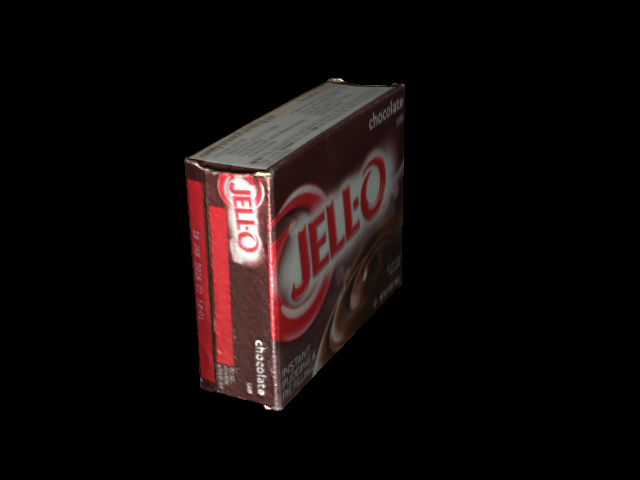

In [2]:
batch = dataset_train[5000][0]
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]

real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render, render_img_original = batch[18:23]
u_map, v_map, x_map, y_map, z_map = batch[23:]


def disp_img_1d(img):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    x_plots = 1
    ax1 = fig.add_subplot(1, x_plots ,1)
    pos = ax1.imshow( img, cmap='Blues' )
    fig.colorbar(pos, ax=ax1)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    plt.show()

print('x_map:')   
disp_img_1d(x_map)
print('y_map:')

disp_img_1d(y_map)
print('z_map:')

disp_img_1d(z_map)
print('u_map:')

disp_img_1d(u_map)
print('v_map:')
disp_img_1d(v_map)

from PIL import Image
print(render_img_original.shape)
display( Image.fromarray(np.uint8(img_orig.numpy())) )
display( Image.fromarray(np.uint8(render_img_original.numpy()[0])) )

# real_img, render_img, real_d, render_d, gt_label_cropped, pred_rot_wxyz, pred_trans, pred_points, h_ren, img_ren = batch[13:]
# img_ren = img_ren[0]


# def get_homo_np(q, t):
#     h = np.eye(4)
#     h[:3,:3] =  quat_to_rot( torch.tensor( q ) ).numpy()
#     h[:3,3] = t
#     return h

# l = label_img.numpy()
# h_render = h_ren[0].numpy()
# h_real= get_homo_np( gt_rot_wxyz[None,:], gt_trans[None,:] )
# idx_ = int( idx[0] ) +1
# cam = 0
# l.shape

# from PIL import Image

# display( Image.fromarray(np.uint8(img_orig) )) 
# u_map, v_map, x_map, y_map, z_map = dataset_train._backend.get_flow(h_render, h_real, idx_, l, cam)

# print('x_map:')   
# disp_img_1d(x_map)
# print('y_map:')

# disp_img_1d(y_map)
# print('z_map:')

# disp_img_1d(z_map)
# print('u_map:')

# disp_img_1d(u_map)
# print('v_map:')
# disp_img_1d(v_map)


# #Dense Version
# big2 = np.concatenate( [img_orig, img_ren], axis=1) 
# img2 = Image.fromarray(np.uint8(big2))
# draw2 = ImageDraw.Draw(img2)

# col = (0, 255, 0)
# grey = (207, 207, 207)
# for _w in range(0,w,5):
#     for _h in range(0,h,5):
#         if label_img[_h,_w] == unique_desig[1]:
#             try:
#                 draw2.line([(_w, _h), (int(_w + v_map[_h,_w]+640), int( _h + u_map[_h,_w]))],
#                   fill=col, width=1)
#             except:
#                 pass
# display(img2)


torch.Size([1, 480, 640, 3])


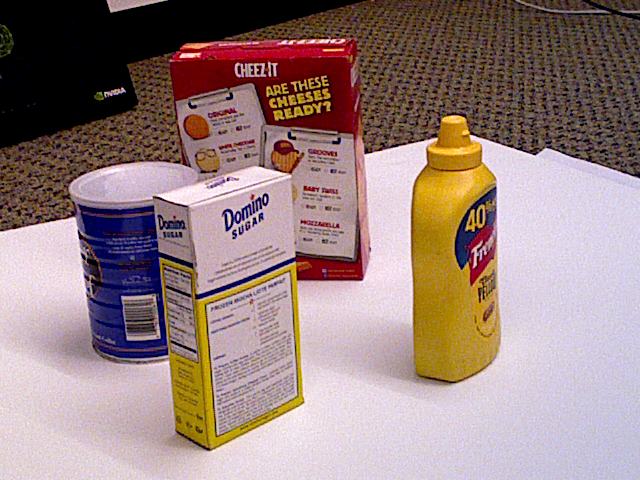

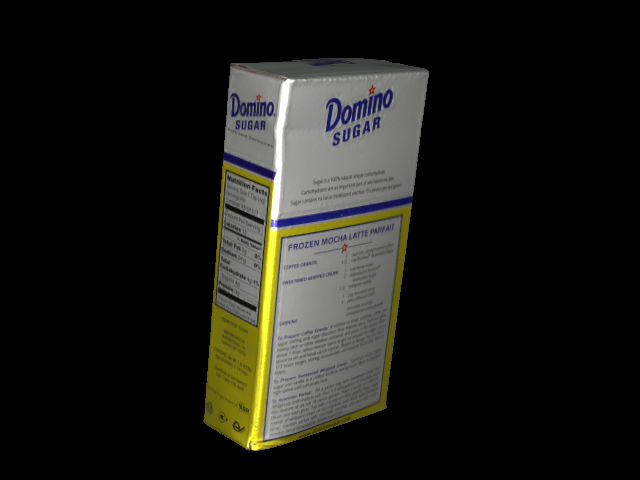

In [69]:
# analyze the mesh info we already have

import os
import numpy as np
import trimesh
import random 
from pathlib import Path

p = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models'
cad_models = [str(p) for p in Path(p).rglob('*.obj')]
print(cad_models[3])
mesh = trimesh.load(cad_models[3])

/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models/019_pitcher_base/textured.obj


In [70]:
def transform_mesh(mesh, H):
    """ directly operates on mesh and does not create a copy!"""
    t = np.ones((mesh.vertices.shape[0],4)) 
    t[:,:3] = mesh.vertices
    mesh.vertices = (t @ H.T)[:,:3]
    return mesh

In [35]:
h= 480
w= 640
cx = 312.9869
cy = 241.3109
fx = 1066.778
fy = 1067.487
K = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]])
u_cor = np.arange(0,h,1)
v_cor = np.arange(0,w,1)
K_inv = np.linalg.inv(K)
rays_dir = np.zeros((h*w,3))
nr = 0

rays_origin_render = np.zeros((h*w,3))
rays_origin_real = np.zeros((h*w,3))
nr_to_image_plane = np.zeros((h*w,2), dtype=np.float)
for u in u_cor:
    for v in v_cor:
        rays_dir[nr,:] = K_inv @ np.array([u,v, 1])  * 0.6 - (K_inv @ np.array([u,v, 1])) * 0.25
        rays_origin_render[nr,:] = K_inv @ np.array([u,v, 1])  * 0.1
        rays_origin_real[nr,:] = K_inv @ np.array([u,v, 1])  * 0.25
        nr_to_image_plane[nr, 0] = u
        nr_to_image_plane[nr, 1] = v
        nr += 1


        

In [96]:
batch = dataset_train[0][0]
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]
real_img, render_img, real_d, render_d, gt_label_cropped, pred_rot_wxyz, pred_trans, pred_points, h_ren, img_ren = batch[13:]
img_ren = img_ren[0]
h,w

dataset_tain._backend.load_flow()
def get_homo_np(q, t):
    h = np.eye(4)
    h[:3,:3] =  quat_to_rot( torch.tensor( q ) ).numpy()
    h[:3,3] = t
    return h

l = label_img.numpy()[0]
h_render = h_ren[0].numpy()
h_real= get_homo_np( gt_rot_wxyz[None,:], gt_trans[None,:] )
idx_ = idx[0]
cam = 0

NameError: name 'dataset_tain' is not defined

In [95]:
p = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models'
cad_models = [str(p) for p in Path(p).rglob('*.obj')]
mesh = {}

cad_models[0].split('/')[-2]

'011_banana'

In [73]:
import copy
from trimesh.ray.ray_pyembree import RayMeshIntersector
from rotations import quat_to_rot
import torch 
from scipy.interpolate import griddata
import time 

def get_homo_np(q, t):
    h = np.eye(4)
    h[:3,:3] =  quat_to_rot( torch.tensor( q ) ).numpy()
    h[:3,3] = t
    return h
max_matches = 500
max_iterations = 5000
grid_x, grid_y = np.mgrid[0:h, 0:w]

# Load correct mesh accroding to desig
obj = list(self._name_to_idx.keys())[unique_desig[1]-1]
for m in cad_models:
    if m.find(obj) != -1:
        

def load_meshes(self):
    p = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models'
    p = self._p_ycb + '/models'
    cad_models = [str(p) for p in Path(p).rglob('*.obj')]
    mesh = {}
    for pa in cad_models:
        mesh[pa.split('/')[-2] ] = trimesh.load(pa)
        
# Make copy to transform the mesh
m_real = copy.deepcopy(mesh)
m_render = copy.deepcopy(mesh)
h_render = h_ren[0].numpy()

h_real= get_homo_np( gt_rot_wxyz[None,:], gt_trans[None,:] )
transform_mesh(m_real, h_real)
transform_mesh(m_render, h_render)

rmi_real = RayMeshIntersector(m_real)
rmi_render = RayMeshIntersector(m_render)

st = time.time()
render_res = rmi_render.intersects_location(ray_origins=rays_origin_render, 
                               ray_directions=rays_dir,
                               multiple_hits=False)
real_res = rmi_real.intersects_location(ray_origins=rays_origin_real, 
                               ray_directions=rays_dir,
                               multiple_hits=False)
# real_res contains: points, mesh, ray

print(f'Total time RMI: {time.time()-st}')
st = time.time()
#coordinate of point in 3D + descriptor(mesh index)
render_des = np.zeros( (h,w,4) ) 
real_des = np.zeros( (h,w,4) )
for i in range(real_res[1].shape[0]):
    u = int(nr_to_image_plane[ real_res[1][i] ][1])
    v = int(nr_to_image_plane[ real_res[1][i] ][0])
    real_des[u,v,:3] = np.array( real_res[0][i] )
    real_des[u,v,3] = real_res[2][i]
for i in range(render_res[1].shape[0]):
    u = int(nr_to_image_plane[ render_res[1][i] ][1])
    v = int(nr_to_image_plane[ render_res[1][i] ][0])
    render_des[u,v,:3] = np.array( render_res[0][i] )
    render_des[u,v,3] = render_res[2][i]
print(f'Total time Array Filling: {time.time()-st}')

st = time.time()

indices = real_des[:,:,3] != 0
uv = np.where(indices == True)
ind2 = render_des[:,:,3] != 0
uv2 = np.where(ind2 == True)
comp = render_des[ind2][:,3][:,None]
disparity_pixels = np.zeros((h,w,2))-999
disparity_world = np.zeros((h,w,3))
evals = int(uv[0].shape[0]/res)

out = [i for i in range(0,uv[0].shape[0]-1)]
random.shuffle( out )
matches = 0
iterations = 0
while matches < max_matches and iterations < max_iterations and iterations < len(out):
    i = out[iterations]
    iterations += 1
    _w, _h = uv[1][i],uv[0][i]
    ind = (comp == real_des[_h,_w,3])
    s = np.where(ind == True) 
    if s[0].shape[0] > 0:
        matches += 1
        u,v = uv2[0][s[0][0]], uv2[1][s[0][0]]                
        disparity_pixels[_h,_w,0] = u - _h
        disparity_pixels[_h,_w,1] = v - _w
        disparity_world[_h,_w,:] = render_des[_h,_w,:3]-real_des[_h,_w,:3]
        
print(f'Disparity {res}-Calculations: {time.time()-st}, Matches {matches} within Iterations {iterations}')

st = time.time()

f_1 = label_img.numpy() == int( unique_desig[1])
f_2 = disparity_pixels[:,:,0] != -999
f_3 = f_1*f_2
points = np.where(f_3!=False)
points = np.stack( [np.array(points[0]), np.array( points[1]) ], axis=1)

u_map = griddata(points, disparity_pixels[f_3][:,0], (grid_x, grid_y), method='nearest')
v_map = griddata(points, disparity_pixels[f_3][:,1], (grid_x, grid_y), method='nearest')
x_map = griddata(points, disparity_world[f_3][:,0], (grid_x, grid_y), method='nearest')
y_map = griddata(points, disparity_world[f_3][:,1], (grid_x, grid_y), method='nearest')
z_map = griddata(points, disparity_world[f_3][:,2], (grid_x, grid_y), method='nearest')


Total time RMI: 1.9864873886108398
(array([[-7.42438131e-02, -7.65918160e-04,  6.23699504e-01],
       [-7.42558494e-02, -1.81678664e-04,  6.23800616e-01],
       [-7.42869342e-02,  4.02853573e-04,  6.24061751e-01],
       ...,
       [ 5.69936940e-03, -2.08473652e-02,  5.52066347e-01],
       [ 5.69550227e-03, -2.03164063e-02,  5.51691760e-01],
       [ 5.69744030e-03, -1.98063300e-02,  5.51879486e-01]]), array([119280, 119281, 119282, ..., 207561, 207562, 207563]), array([197449, 196611, 196823, ..., 280984,  40641,  40647], dtype=int32))
Total time Array Filling: 0.2688472270965576
Disparity 100-Calculations: 0.2239985466003418, Matches 500 within Iterations 985


x_map:


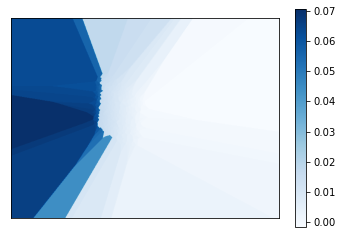

y_map:


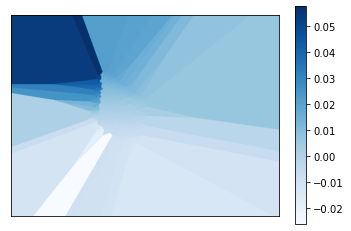

z_map:


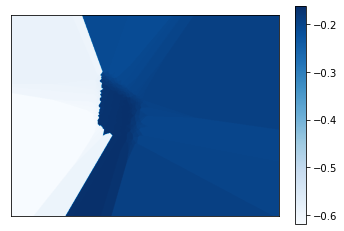

u_map:


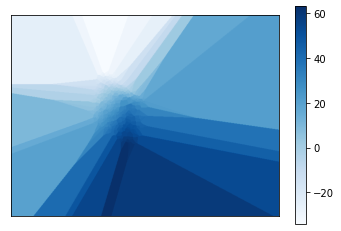

v_map:


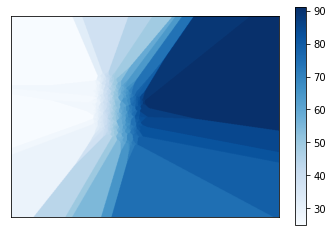

In [18]:
def disp_img_1d(img):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    x_plots = 1
    ax1 = fig.add_subplot(1, x_plots ,1)
    pos = ax1.imshow( img, cmap='Blues' )
    fig.colorbar(pos, ax=ax1)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    plt.show()
print('x_map:')   
disp_img_1d(x_map)
print('y_map:')

disp_img_1d(y_map)
print('z_map:')

disp_img_1d(z_map)
print('u_map:')

disp_img_1d(u_map)
print('v_map:')
disp_img_1d(v_map)


In [36]:
from PIL import ImageDraw

big = np.concatenate( [img_orig, img_ren], axis=1) 
img = Image.fromarray(np.uint8(big))
draw = ImageDraw.Draw(img)

col = (0, 255, 0)
grey = (207, 207, 207)
for _w in range(0,w,5):
    for _h in range(0,h,5):
        if label_img[_h,_w] == unique_desig[1] and (disparity_pixels[_h,_w,0] != -999 or disparity_pixels[_h,_w,1] != -999):
            try:
                draw.line([(_w, _h), (_w + disparity_pixels[_h,_w,1]+640, _h + disparity_pixels[_h,_w,0])],
                  fill=col, width=1)
            except:
                pass
display(img)


#Dense Version
big2 = np.concatenate( [img_orig, img_ren], axis=1) 
img2 = Image.fromarray(np.uint8(big2))
draw2 = ImageDraw.Draw(img2)

col = (0, 255, 0)
grey = (207, 207, 207)
for _w in range(0,w,5):
    for _h in range(0,h,5):
        if label_img[_h,_w] == unique_desig[1]:
            try:
                draw2.line([(_w, _h), (int(_w + v_map[_h,_w]+640), int( _h + u_map[_h,_w]))],
                  fill=col, width=1)
            except:
                pass
display(img2)

NameError: name 'disparity_pixels' is not defined

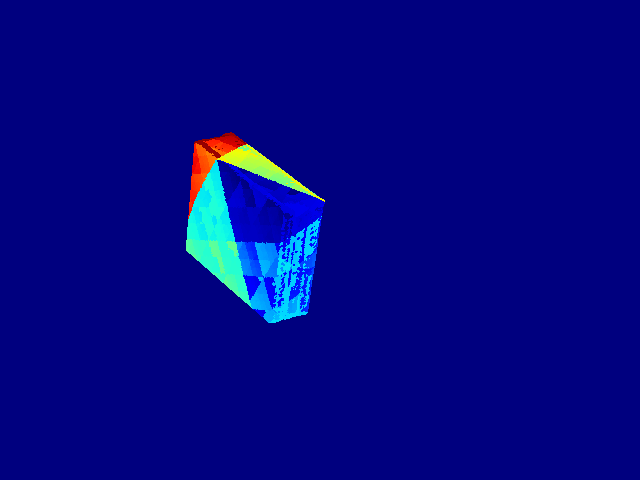

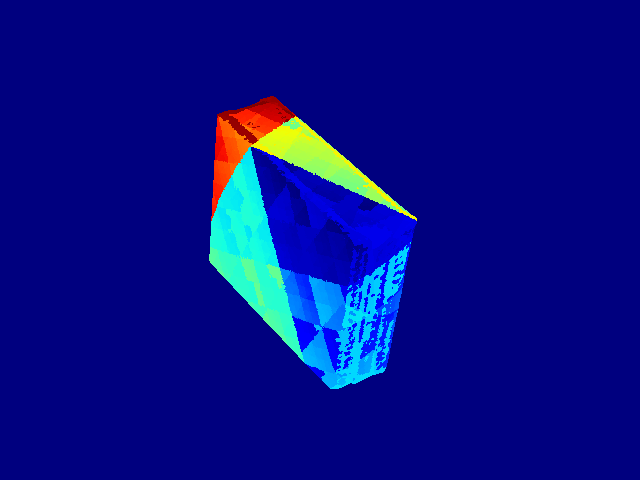

In [76]:
from matplotlib import cm
from PIL import Image
# plot the corrosponding meshed !
jet = cm.get_cmap('jet')
c = int( max( np.max(real_des[:,:,3]), np.max(render_des[:,:,3])) ) +1
SEG_COLORS = (np.stack([jet(v) for v in np.linspace(0, 1, c)]) * 255).astype(np.uint8)

def plot(label):
    image_out = np.zeros(
    (label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for h in range(label.shape[0]):
        for w in range(label.shape[1]):
            image_out[h, w, :] = SEG_COLORS[int(label[h, w])][:3]
    display(Image.fromarray(np.uint8(image_out)))
    return image_out

im_out2 = plot(real_des[:,:,3])
im_out = plot(render_des[:,:,3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(480, 640) (480, 640) (480, 640, 2)
(500, 2)
(480, 640, 3)


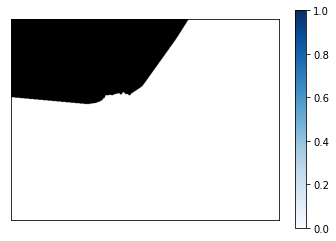

In [77]:
"""
DEPRECATED
DEPRECATED
DEPRECATED
DEPRECATED
DEPRECATED
DEPRECATED
"""

label_img.shape

from scipy.interpolate import griddata
f_1 = label_img.numpy() == int( unique_desig[1])
f_2 = disparity_pixels[:,:,0] != -999

f_3 = f_1*f_2
points = np.where(f_3!=False)
points = np.stack( [np.array(points[0]), np.array( points[1]) ], axis=1)

# print(f_3[:,:,None].repeat(3,3).shape)
# o = f_3[:,:,None](1,1,2)
print(f_1.shape, f_2.shape , disparity_pixels.shape)
print( disparity_pixels[f_3].shape )

grid_x, grid_y = np.mgrid[0:h, 0:w]
grid_z0 = griddata(points, disparity_pixels[f_3][:,0], (grid_x, grid_y), method='nearest')
o = np.repeat( np.expand_dims(grid_z0,2),3,2)
print(o.shape)
disp_img(o)

[-0.03063223 -0.0080317   0.19264099]
Input t: [-0.03063223 -0.0080317   0.19264099]
R1 
 [[ 0.1569061   0.04114041 -0.98675627]
 [-0.25362452  0.96730275  0.        ]
 [ 0.95449205  0.25026559  0.16220992]] 

R2 
 [[ 0.1569061   0.04114041 -0.98675627]
 [-0.25362452  0.96730275  0.        ]
 [ 0.95449205  0.25026559  0.16220992]] 

P1 
 [[ 1.06748700e+03  0.00000000e+00 -4.56859171e+03  0.00000000e+00]
 [ 0.00000000e+00  1.06748700e+03  1.39935956e+03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]] 

P2 
 [[ 1.06748700e+03  0.00000000e+00 -4.56859171e+03 -2.08401769e+02]
 [ 0.00000000e+00  1.06748700e+03  1.39935956e+03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]] 



NameError: name 'objp' is not defined

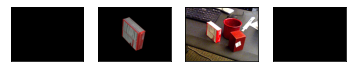

In [78]:
import cv2

distCoeffs1 = np.array([0,0,0,0])
distCoeffs2 = np.array([0,0,0,0])
cameraMatrix1 = K
cameraMatrix2 = K

h_real_inv = np.eye(4)
h_real_inv[:3,:3] = np.linalg.inv(h_real[:3,:3])
h_real_inv[:3,3] = - h_real_inv[:3,:3] @ h_real[:3,3]

h_render_inv = np.eye(4)
h_render_inv[:3,:3] = np.linalg.inv(h_render[:3,:3])
h_render_inv[:3,3] = - h_render_inv[:3,:3] @ h_render[:3,3]

h_real_to_render = h_real_inv @ h_render


  
def val(r,t):
    # 
    # r = R.from_euler('z', 270, degrees=True).as_matrix() 
    dist = np.array([0,0,0,0])
    print(f'Input t: {t}')
    R1, R2, P1, P2, *_ = cv2.stereoRectify(cameraMatrix1, dist, cameraMatrix2, dist ,(w,h), r,t)
    map1, map2 = cv2.initUndistortRectifyMap(cameraMatrix1, dist, R1 , P1, (w,h), cv2.CV_32FC1)

#     print('T', T, 'RES0', R1, R2)
    print(f'R1 \n {R1} \n')
    print(f'R2 \n {R2} \n')
    print(f'P1 \n {P1} \n')
    print(f'P2 \n {P2} \n')

    for i in range( 200,210):
        for j in range (200,210):
            u = map1[i,j]
            v = map2[i,j]
#             print( f'coordintate {i},{j} is mapped to {u},{v}')  

    inp  = np.transpose( img_orig.numpy(), (0,1,2) )
    inp2  = np.transpose( img_ren.numpy(), (0,1,2) )
    img_out = cv2.remap( inp , map1, map2,
          interpolation=cv2.INTER_NEAREST,
          borderMode=cv2.BORDER_CONSTANT,
          borderValue=(0, 0, 0, 0))
    img_out2 = cv2.remap( inp2 , map1, map2,
          interpolation=cv2.INTER_NEAREST,
          borderMode=cv2.BORDER_CONSTANT,
          borderValue=(0, 0, 0, 0))
        
    # display([ Image.fromarray(np.uint8( img_out )), Image.fromarray(np.uint8( img_ren ))] ) 
    # display(Image.fromarray(np.uint8( img_ren ))) 
    # display(Image.fromarray(np.uint8(img_orig ))) 
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax1 = fig.add_subplot(1,4,1)
    ax1.imshow( Image.fromarray(np.uint8( img_out )) )
    ax2 = fig.add_subplot(1,4,2)
    ax2.imshow(Image.fromarray(np.uint8( img_ren )))
    ax3 = fig.add_subplot(1,4,3)
    ax3.imshow(Image.fromarray(np.uint8( img_orig )))
    ax4 = fig.add_subplot(1,4,4)
    ax4.imshow(Image.fromarray(np.uint8( img_out2 )))
    ax4.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    fig.show()
    
t = h_real[:3,3] - h_render[:3,3]
print(t)
from scipy.spatial.transform import Rotation as R
val(R.from_euler('z', 0, degrees=True).as_matrix()  ,t)  #np.array([0.6,0,0.4])
# val(np.eye(3),np.array([0,0.5,0]))
# val(np.eye(3),np.array([0.5,0,0]))
# val(np.eye(3),np.array([0.5,0.5,0.5]))
# val(np.eye(3),np.array([0.5,0.5,0]))


ret, K1, D1, K2, D2, R, T, E, F = cv2.stereoCalibrate(objp, leftp, rightp, K1, D1, K2, D2, image_size)

# cv2.__version__
# cameraMatrix1 


# grid_x, grid_y = np.mgrid[0:h, 0:w]
# points.shape
# whichImage = 0
# import cv2
# imagePoints = []
# imagePoints2 = []
# objectPoints = []
# for u in range(0,h,10):
#     for v in range(0,w,10):
#         if real_des[u,v,3] != 0:
            
            
            
#             ind = (render_des[:,:,3] == real_des[u,v,3])
#             _u,_v = np.where(ind == True) 
#             if len(_u) > 0:
#                 imagePoints.append(np.array( [u,v],  dtype = np.float32)) 
#                 imagePoints2.append(np.array([_u[0],_v[0]], dtype = np.float32))
#                 objectPoints.append( np.array( real_des[u,v,:3],dtype=np.float32) )
# #                 print(f'added {imagePoints[-1]} {objectPoints[-1]}')
            

# cameraMatrix = K

# F, mask = cv2.findFundamentalMat(np.array( imagePoints ) , np.array( imagePoints2 ) ,cv2.FM_LMEDS)
# # print(np.array(objectPoints).shape, np.array( imagePoints).shape)
# # res = cv2.calibrateCamera(objectPoints[:10], imagePoints[:10], (h,w), None,None)

# points = np.concatenate( [grid_x[:,:,None],grid_y[:,:,None]],2) 
# points = points.reshape(-1,2)
# lines = cv2.computeCorrespondEpilines(points, 0, F)


#What am i doing. Fuck 

# # grid_x, grid_y = np.mgrid[0:h, 0:w]
# # map_orgi = np.concatenate( [grid_x[:,:,None],grid_y[:,:,None]],2) 

# print('GRID', grid_x.shape,grid_y)


# #         inp  = img_orig.numpy()
# #         print(inp.shape, map1.shape)
# #         new_real = cv2.remap(inp, map1, map2,
# #                               interpolation=cv2.INTER_NEAREST,
# #                               borderMode=cv2.BORDER_CONSTANT,
# #                               borderValue=(0, 0, 0, 0))

# #     display(Image.fromarray(np.uint8(new_real)))         
# #     print('MAP1',map1)
# #     display(Image.fromarray(np.uint8(img_rend)))

# import numpy.linalg as la
# def rectify_images_float(img1, H1, img2, H2, K, d, shearing=False):
#     imsize = (img1.shape[1], img1.shape[0])
#     if shearing:
#         S = epipolar.rectify_shearing(H1, H2, imsize)
#         H1 = S.dot(H1)
#     rH = la.inv(K).dot(H1).dot(K)
#     lH = la.inv(K).dot(H2).dot(K)
    
    
    
#     map1x, map1y = cv2.initUndistortRectifyMap(K, d, rH, K, imsize, cv.CV_16SC2)
#     map2x, map2y = cv2.initUndistortRectifyMap(K, d, lH, K, imsize, cv.CV_16SC2)

#     rimg1 = cv2.remap(img1, map1x, map1y,
#                       interpolation=cv.INTER_NEAREST,
#                       borderMode=cv2.BORDER_CONSTANT,
#                       borderValue=(0, 0, 0, 0))
#     rimg2 = cv2.remap(img2, map2x, map2y,
#                       interpolation=cv.INTER_NEAREST,
#                       borderMode=cv2.BORDER_CONSTANT,
#                       borderValue=(0, 0, 0, 0))

#     return rimg1, rimg2

# rimg1, rimg2 = rectify_images_float(img_orig, h_real_inv, img_ren, h_render_inv, K, distCoeffs1 )
# display(Image.fromarray(np.uint8(rimg1)))